## Mini AlexNet Baseline Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [1]:
import sys
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import import_ipynb
import RMT_Util

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

print(sys.version)
print("numpy version {}".format(np.__version__))
print("tensforflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))
print("sklearn version {}".format(sklearn.__version__))

/Users/charlesmartin14/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charlesmartin14/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing notebook from RMT_Util.ipynb
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
scipy version 1.0.1
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1
powerlaw version 1.4.3
3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.2
tensforflow version 1.5.0-dev20171116
keras version 2.1.5
sklearn version 0.19.1


In [2]:
BASELINE_outfile = 'results/cifar10_alexnet.out'

BASELINE_final_weightfile = 'weights/alexnet.b16.final.h5'
BASELINE_per_epoch_weightfile = "weights/alexnet.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 100

BASELINE_init_weighfile = 'weights/alexnet.b16.e0.h5'

REGULARIZED_final_weightfile = 'weights/alexnet.b16.wd.final.h5'
RANDOMIZED_final_weightfile = 'weights/alexnet.b16.rand100.final.h5'

BASELINE_ensemble_weightfile = "weights/alexnet.b16.id{}.final.h5"
NUM_ENSEMBLE_RUNS = 10


CIFAR_TEST_BATCH = "./data/cifar-10-batches-py/test_batch"

N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

LAYER_FC1 = 7
LAYER_FC2 = 8

ENTROPY_FILE = "img/mini-alexnet-baseline-entropy-per-epoch.png"
RANK_FILE = "img/mini-alexnet-baseline-rank-per-epoch.png"

ACCURACY_FILE = "img/mini-alexnet-baseline-accuracy-per-epoch.png"

FC1_ESD_PER_EPOCH_FILE = "img/mini-alexnet-fc1-esd-per-epoch.png"
FC2_ESD_PER_EPOCH_FILE = "img/mini-alexnet-fc2-esd-per-epoch.png"

ALPHA = 0.25 # not passing through

XLABEL_FC1 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC1}^{T}\mathbf{W}_{FC1}$"
XLABEL_FC2 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC2}^{T}\mathbf{W}_{FC2}$"

XLABEL = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}}^{T}\mathbf{W}$"
YLABEL = r"$\rho_{NR}(\lambda) shuffled 100X$"
YLABEL_1RUN = r"$\rho_{emp}(\lambda)$"


ESD_FC1_0_EPOCH = "img/mini-alexnet-fc1-esd-epoch-0.png"
ESD_FC2_0_EPOCH = "img/mini-alexnet-fc2-esd-epoch-0.png"
ESD_FC1_FINAL_EPOCH = "img/mini-alexnet-fc1-esd-epoch-final.png"
ESD_FC2_FINAL_EPOCH = "img/mini-alexnet-fc2-esd-epoch-final.png"

ENSEMBLE_ESD_FC1_0_EPOCH = "img/mini-alexnet-fc1-ensemble-esd-epoch-0.png"
ENSEMBLE_ESD_FC2_0_EPOCH = "img/mini-alexnet-fc2-ensemble-esd-epoch-0.png"
ENSEMBLE_ESD_FC1_FINAL_EPOCH = "img/mini-alexnet-fc1-ensemble-esd-epoch-final.png"
ENSEMBLE_ESD_FC2_FINAL_EPOCH = "img/mini-alexnet-fc2-ensemble-esd-epoch-final.png"

In [3]:
plt.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams.update({'font.size': 16})
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

<Figure size 360x360 with 0 Axes>

In [4]:
!cd weights; ln -s alexnet.b16.final.h5 alexnet.b16.e100.h5
!cd weights; ls -l alexnet.b16.e100.h5

ln: alexnet.b16.e100.h5: File exists
lrwxr-xr-x  1 charlesmartin14  staff  20 Apr 10 23:41 alexnet.b16.e100.h5 -> alexnet.b16.final.h5


In [5]:
!ls weights/*final*

weights/alexnet.b100.id1.final.h5
weights/alexnet.b100.id10.final.h5
weights/alexnet.b100.id2.final.h5
weights/alexnet.b100.id3.final.h5
weights/alexnet.b100.id4.final.h5
weights/alexnet.b100.id5.final.h5
weights/alexnet.b100.id6.final.h5
weights/alexnet.b100.id7.final.h5
weights/alexnet.b100.id8.final.h5
weights/alexnet.b100.id9.final.h5
weights/alexnet.b1000.id1.final.h5
weights/alexnet.b1000.id1.final.h5.gz
weights/alexnet.b1000.id10.final.h5
weights/alexnet.b1000.id2.final.h5
weights/alexnet.b1000.id3.final.h5
weights/alexnet.b1000.id4.final.h5
weights/alexnet.b1000.id5.final.h5
weights/alexnet.b1000.id6.final.h5
weights/alexnet.b1000.id7.final.h5
weights/alexnet.b1000.id8.final.h5
weights/alexnet.b1000.id9.final.h5
weights/alexnet.b150.id1.final.h5
weights/alexnet.b150.id10.final.h5
weights/alexnet.b150.id2.final.h5
weights/alexnet.b150.id3.final.h5
weights/alexnet.b150.id4.final.h5
weights/alexnet.b150.id5.final.h5
weights/alexnet.b150.id6.final.h5
weights/alexnet.b150.id7.final.

## Baseline 

In [6]:
model = RMT_Util.Alexnet_Model()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
model.load_weights(BASELINE_final_weightfile)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

#### Check baseline shapes

In [8]:
for il, layer in enumerate(model.layers):
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print("layer ",il,": ", W.shape)

layer  0 :  (5, 5, 3, 96)
layer  2 :  (96,)
layer  3 :  (5, 5, 96, 256)
layer  5 :  (256,)
layer  7 :  (4096, 384)
layer  8 :  (384, 192)
layer  9 :  (192, 10)


### Compute Entropy and Stable Rank per Epoch

Baseline has 100 epochs.

In [9]:
fc1_entropies, fc2_entropies = [], []
fc1_ranks, fc2_ranks = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    fc1_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC1))
    fc2_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC2))
    
    fc1_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC1))
    fc2_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC2))

In [10]:
assert(len(fc1_entropies)==NUM_BASELINE_EPOCHS)
assert(len(fc2_entropies)==NUM_BASELINE_EPOCHS)
assert(len(fc1_ranks)==NUM_BASELINE_EPOCHS)
assert(len(fc2_ranks)==NUM_BASELINE_EPOCHS)

saved file img/mini-alexnet-baseline-entropy-per-epoch.png


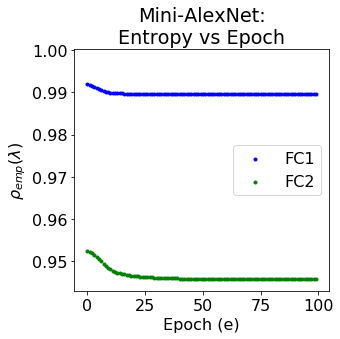

In [47]:
plt.scatter(range(0,len(fc1_entropies)), fc1_entropies, marker='.', color='blue', label="FC1")
plt.scatter(range(0,len(fc2_entropies)), fc2_entropies, marker='.', color='green', label="FC2")
#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet:\nEntropy vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel(r"$\rho_{emp}(\lambda)$")
plt.legend()

plt.tight_layout()


plt.savefig(ENTROPY_FILE)
print("saved file {}".format(ENTROPY_FILE))

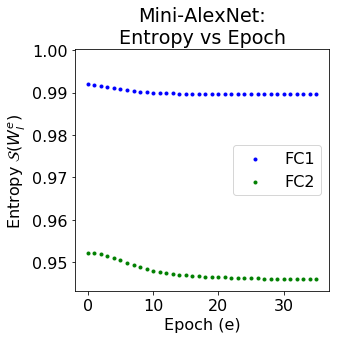

In [45]:
plt.scatter(range(0,len(fc1_entropies[0:36])), fc1_entropies[0:36], marker='.', color='blue', label="FC1")
plt.scatter(range(0,len(fc2_entropies[0:36])), fc2_entropies[0:36], marker='.', color='green', label="FC2")
#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet:\nEntropy vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Entropy $\mathcal{S}({W}^{e}_{l})$")
plt.legend()
plt.tight_layout()



saved file img/mini-alexnet-baseline-rank-per-epoch.png


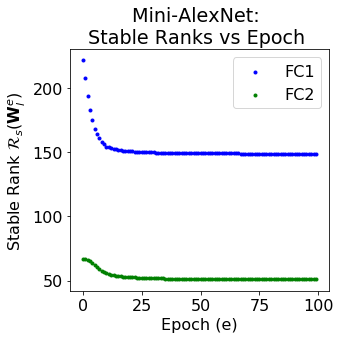

In [43]:
plt.scatter(range(0,len(fc1_ranks)), fc1_ranks, marker='.', color='blue', label="FC1")
plt.scatter(range(0,len(fc2_ranks)), fc2_ranks, marker='.', color='green', label="FC2")
#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet: \nStable Ranks vs Epoch ')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Stable Rank $\mathcal{R}_{s}(\mathbf{W}^{e}_{l})$")
plt.legend()
plt.tight_layout()

plt.savefig(RANK_FILE)
print("saved file {}".format(RANK_FILE))

### Zoom in a bit, but do not save figure

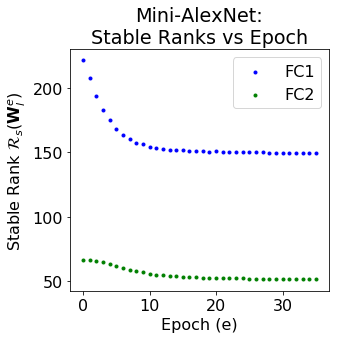

In [44]:
plt.scatter(range(0,len(fc1_ranks[0:36])), fc1_ranks[0:36], marker='.', color='blue', label="FC1")
plt.scatter(range(0,len(fc2_ranks[0:36])), fc2_ranks[0:36], marker='.', color='green', label="FC2")
#lt.ylim([0.905,0.920])
plt.title('Mini-AlexNet:\nStable Ranks vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel(r"Stable Rank $\mathcal{R}_{s}(\mathbf{W}^{e}_{l})$")
plt.legend()
plt.tight_layout()



### Read Training Accuracies

We can simply parse these from the output file

### Recompute Test Accuracies

In [15]:
test_images, test_labels = RMT_Util.read_test_images(datadir="./data")

Loading test images...


#### Read Baseline Training accuracies from output file

Notice: there is no epoch=0 training accuracy

In [16]:
bsln_train_accs = RMT_Util.read_training_accuracies(BASELINE_outfile)
assert(len(bsln_train_accs)==NUM_BASELINE_EPOCHS)

#### Recompute Baseline Test accuracies 

In [17]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [18]:
bsln_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(test_images),np.array(test_labels), batch_size=256)
    bsln_test_accs.append(acc[1])

10000/10000 [==============================] - 25s 3ms/step



### Training and test Accuracies vs Epoch

In [19]:
len(bsln_train_accs), len(bsln_test_accs)

(100, 100)

saved file img/mini-alexnet-baseline-accuracy-per-epoch.png


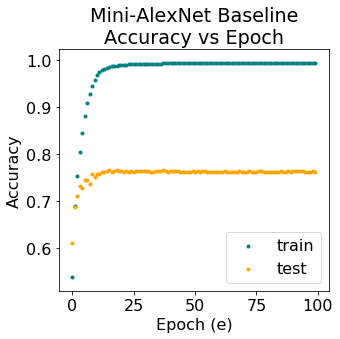

In [31]:
x = range(NUM_BASELINE_EPOCHS)

plt.scatter(x, bsln_train_accs,  marker='.',color='teal', label="train")
plt.scatter(x, bsln_test_accs,  marker='.',color='orange', label="test")
plt.title('Mini-AlexNet Baseline\nAccuracy vs Epoch')
plt.xlabel("Epoch (e)")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()


plt.savefig(ACCURACY_FILE)
print("saved file {}".format(ACCURACY_FILE))

## Create 25 ESD plots, 5x5 grid

In [21]:
plt.rcParams['figure.figsize'] = [12, 12]
HSPACE = 0.5

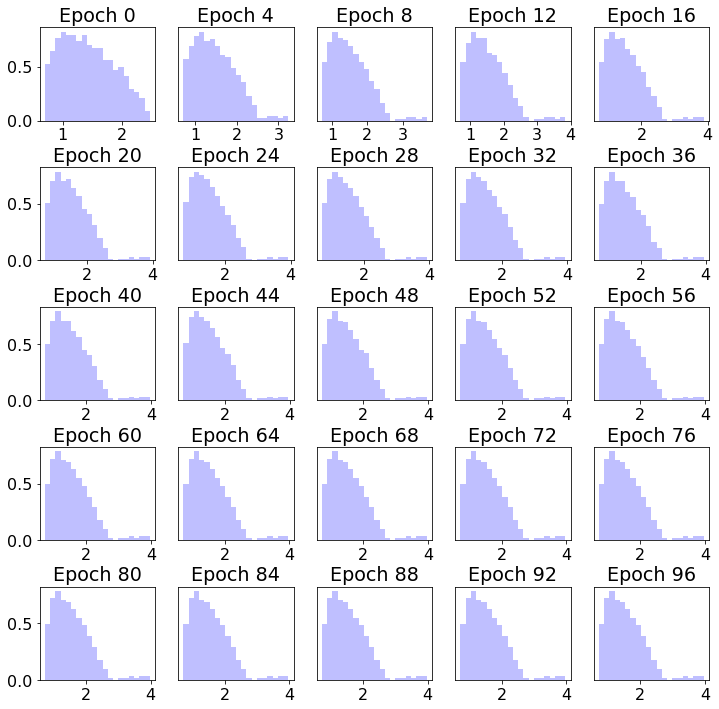

In [22]:
f, axes = plt.subplots(5,5)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, layer=LAYER_FC1)

    iay = idx % 5
    iax = int(idx / 5)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]

    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));
    if iay > 0:
        subplot.get_yaxis().set_visible(False)
    
f.subplots_adjust(hspace=HSPACE)
#plt.savefig(FC1_ESD_PER_EPOCH_FILE)

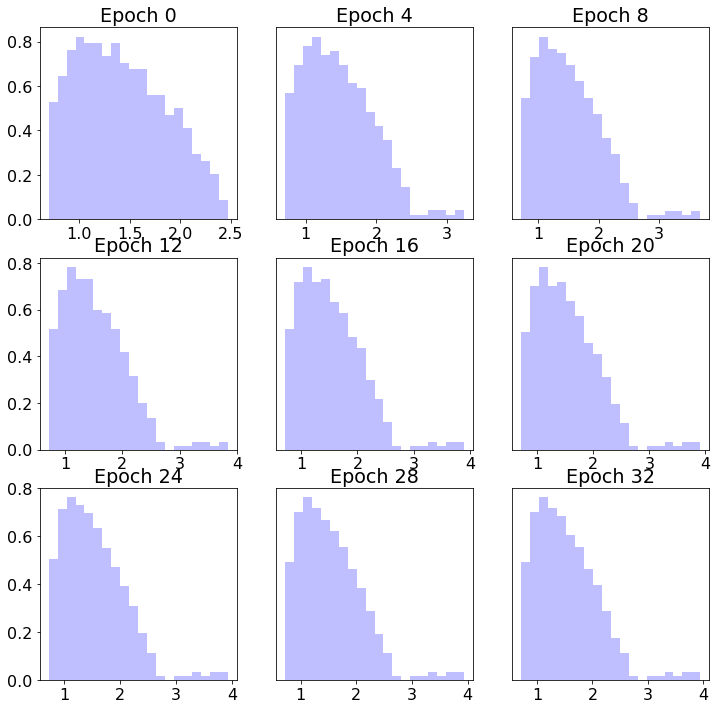

In [23]:
f, axes = plt.subplots(3,3)

for idx, epoch in enumerate(np.arange(0,33,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, layer=LAYER_FC1)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]

    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));
    if iay > 0:
        subplot.get_yaxis().set_visible(False)
    
#f.subplots_adjust(hspace=HSPACE)
plt.savefig(FC1_ESD_PER_EPOCH_FILE)

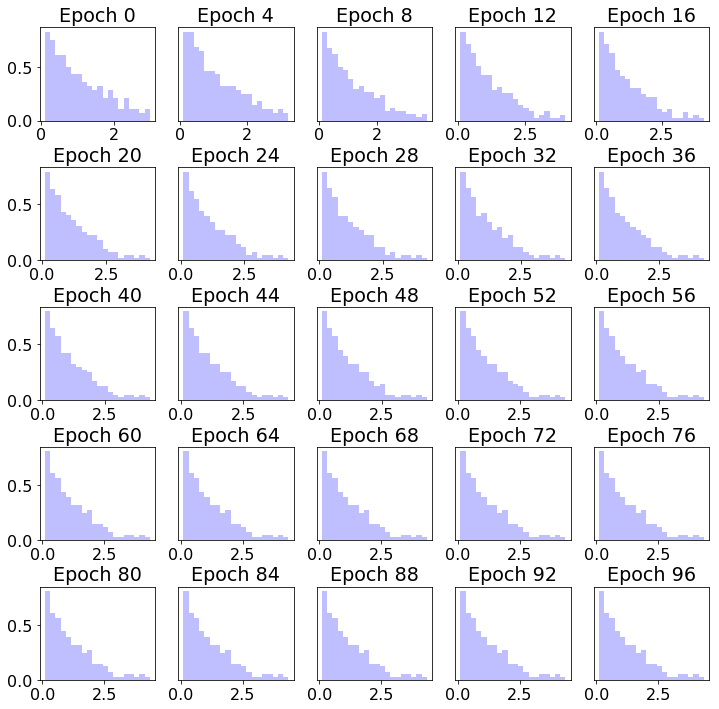

In [24]:
f, axes = plt.subplots(5,5)

for idx, epoch in enumerate(np.arange(0,NUM_BASELINE_EPOCHS,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, layer=LAYER_FC2)

    iay = idx % 5
    iax = int(idx / 5)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));
    if iay > 0:
        subplot.get_yaxis().set_visible(False)
    
f.subplots_adjust(hspace=HSPACE)
#plt.savefig(FC2_ESD_PER_EPOCH_FILE)

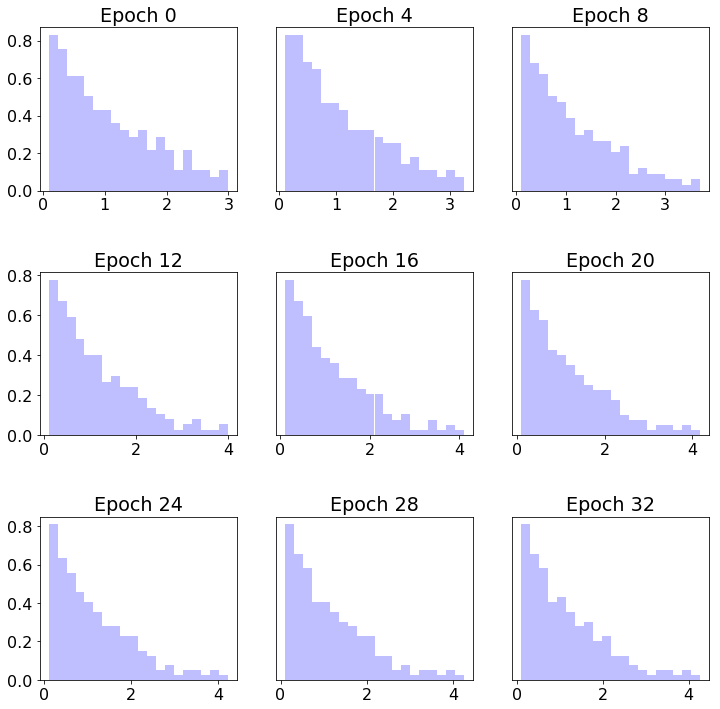

In [25]:
f, axes = plt.subplots(3,3)

for idx, epoch in enumerate(np.arange(0,33,4)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, layer=LAYER_FC2)

    iay = idx % 3
    iax = int(idx / 3)
    #print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue', density=True);
    subplot.set_title("Epoch {}".format(epoch));
    if iay > 0:
        subplot.get_yaxis().set_visible(False)
    
f.subplots_adjust(hspace=HSPACE)
plt.savefig(FC2_ESD_PER_EPOCH_FILE)

### Fit Marchenko Pastur to ESD at different Epochs


In [26]:
plt.rcParams['figure.figsize'] = [5,5]

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 0.00
% sigma 1.2036
saved figure img/mini-alexnet-fc1-esd-epoch-0.png


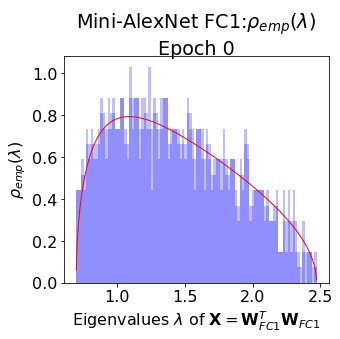

In [38]:
epoch=0

modelfile = BASELINE_per_epoch_weightfile.format(epoch)

eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, LAYER_FC1)
plt.hist(eigenvalues, bins=50, alpha=0.25, color='blue', density=True);

RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=0)


plt.title(r"Mini-AlexNet FC1:$\rho_{emp}(\lambda)$"+"\nEpoch {}".format(epoch))
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL_1RUN)
plt.tight_layout()


filename = ESD_FC1_0_EPOCH
plt.savefig(filename)
print("saved figure {}".format(filename))


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 0.00
% sigma 1.0126
saved figure img/mini-alexnet-fc2-esd-epoch-0.png


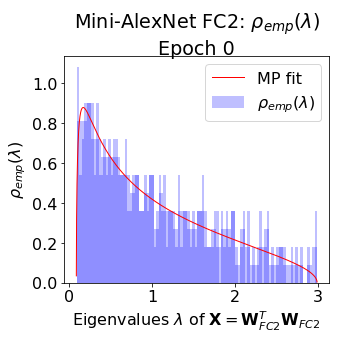

In [37]:
epoch=0

modelfile = BASELINE_per_epoch_weightfile.format(epoch)

eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, LAYER_FC2)
plt.hist(eigenvalues, bins=50, alpha=0.25, color='blue', density=True);

RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q8, num_spikes=0)


plt.title(r"Mini-AlexNet FC2: $\rho_{emp}(\lambda)$"+"\nEpoch {}".format(epoch))
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL_1RUN)
plt.legend()
plt.tight_layout()


filename = ESD_FC2_0_EPOCH
plt.savefig(filename)
print("saved figure {}".format(filename))

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 2.40
% sigma 1.2576
saved figure img/mini-alexnet-fc1-esd-epoch-final.png


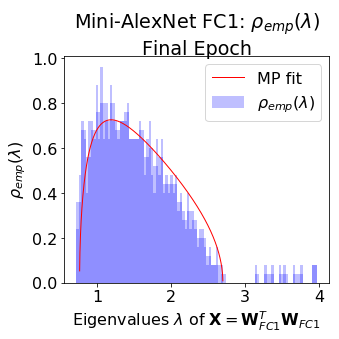

In [36]:
modelfile = BASELINE_final_weightfile

eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, LAYER_FC1)
plt.hist(eigenvalues, bins=50, alpha=0.25, color='blue', density=True);

RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q7, num_spikes=9)


plt.title(r"Mini-AlexNet FC1: $\rho_{emp}(\lambda)$"+"\nFinal Epoch")
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL_1RUN)
plt.legend()
plt.tight_layout()


filename = ESD_FC1_FINAL_EPOCH
plt.savefig(filename)
print("saved figure {}".format(filename))


RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 4.92
% sigma 1.0010
saved figure img/mini-alexnet-fc2-esd-epoch-final.png


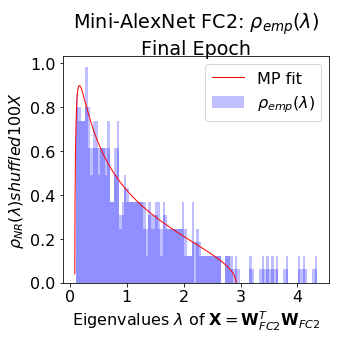

In [34]:
modelfile = BASELINE_final_weightfile

eigenvalues = RMT_Util.get_eigenvalues(model, modelfile, LAYER_FC2)
plt.hist(eigenvalues, bins=50, alpha=0.25, color='blue', density=True);

RMT_Util.plot_ESD_and_fit(eigenvalues, Q=Q8, num_spikes=9)


plt.title(r"Mini-AlexNet FC2: $\rho_{emp}(\lambda)$"+\nFinal Epoch")
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename = ESD_FC2_FINAL_EPOCH
plt.savefig(filename)
print("saved figure {}".format(filename))
